In [1]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as pdd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
alggf_data = pdd.DataReader('ALGGF', data_source='yahoo', start='2020-01-01', end = '2022-10-10')

In [3]:
alggf_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,0.220,0.220,0.220,0.220,0.0,0.21814
2020-01-02,0.220,0.220,0.220,0.220,0.0,0.21814
2020-01-03,0.220,0.220,0.220,0.220,0.0,0.21814
2020-01-06,0.220,0.220,0.220,0.220,0.0,0.21814
2020-01-07,0.220,0.220,0.220,0.220,0.0,0.21814
...,...,...,...,...,...,...
2022-10-04,0.182,0.182,0.182,0.182,0.0,0.18200
2022-10-05,0.182,0.182,0.182,0.182,0.0,0.18200
2022-10-06,0.182,0.182,0.182,0.182,0.0,0.18200


<AxesSubplot:xlabel='Date'>

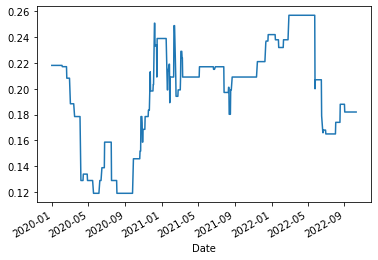

In [4]:
y_alggf = alggf_data['Adj Close']
y_alggf.index=alggf_data.index
y_alggf.plot()

In [5]:
y_alggf = y_alggf.values

In [6]:
training_size = int(y_alggf.size * 0.8)
print(training_size)

560


In [7]:
training_mean = y_alggf[:training_size].mean()
training_std = y_alggf[:training_size].std()
# standarize the data
y_alggf = (y_alggf-training_mean)/training_std

In [8]:
y_alggf[0:5]

array([0.60160623, 0.60160623, 0.60160623, 0.60160623, 0.60160623])

In [9]:
def data_preprocess(dataset, iStart, iEnd, sHistory):
  data = []
  target = []
  # begin with sHistory to have historical data
  iStart += sHistory
  if iEnd is None:
    iEnd = len(dataset)
  for i in range(iStart, iEnd):
    indices = range(i-sHistory, i)
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
    target.append(dataset[i])
  return np.array(data), np.array(target)

In [10]:
past_history = 10
xtrain, ytrain = data_preprocess(y_alggf, 0, training_size, past_history)
xtest, ytest = data_preprocess(y_alggf, training_size, None, past_history)

In [11]:
xtest[0]

array([[1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248]])

In [12]:
xtest[1]

array([[1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248],
       [1.56923248]])

In [13]:
tf.random.set_seed(8888)
model_alggf = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]), tf.keras.layers.Dense(1)])

In [14]:
model_alggf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_alggf.compile(optimizer='Adam', loss='mse')

In [16]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [17]:
history = model_alggf.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 11s 21ms/step - loss: 0.2383 - val_loss: 0.1159
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0562 - val_loss: 0.0648
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0448 - val_loss: 0.0499
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0403 - val_loss: 0.0421
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0363 - val_loss: 0.0375
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0337 - val_loss: 0.0341
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0323 - val_loss: 0.0321
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0301 - val_loss: 0.0307
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0285
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0273 - val_loss: 0.0

In [18]:
hist_alggf = pd.DataFrame(history.history)
hist_alggf.head()

,loss,val_loss
0,0.238258,0.115860
1,0.056229,0.064754
2,0.044772,0.049926
3,0.040346,0.042096
4,0.036294,0.037497


<AxesSubplot:>

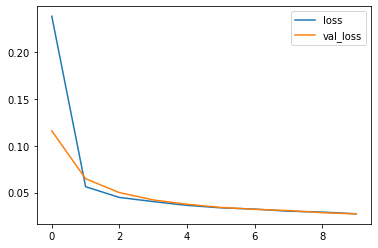

In [19]:
hist_alggf.plot()

In [20]:
predicted_value = []
alggf_orig = []
count =0;
for x, y in p_train.take(20):
  alggf_orig.append(y[0].numpy())
  t_pred= model_alggf.predict(x)
  predicted_value.append(t_pred[0])

1/1 [==============================] - 0s 30ms/step


<AxesSubplot:>

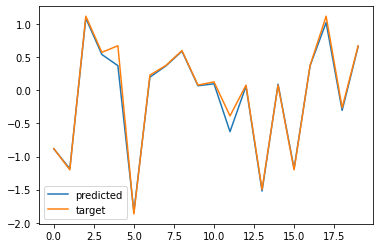

In [21]:
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result_alggf = pd.DataFrame({'predicted':y_pred, 'target':alggf_orig})
result_alggf.plot()

In [22]:
(result_alggf).to_csv("agbayani_alggf_forecast.csv")